In [1]:
# referensi: https://www.kaggle.com/code/josephvm/mnist-with-pytorch

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import cv2
import mediapipe as mp
import torch, torchvision

d:\disertasi\handGestureDetection\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# load data
from torch.utils.data import Dataset
import pandas as pd
import os
from torchvision.io import read_image
from sklearn.model_selection import train_test_split

test_images = pd.read_csv("dataHandSign/archive/sign_mnist_test/sign_mnist_test.csv")
train_set = pd.read_csv("dataHandSign/archive/sign_mnist_train/sign_mnist_train.csv")

train_images, val_images, train_labels, val_labels = train_test_split(train_set.iloc[:,1:], train_set.iloc[:,0], test_size=0.2)
# print(train_images)
train_images.reset_index(drop=True, inplace=True)
val_images.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)
val_labels.reset_index(drop=True, inplace=True)


In [13]:
pd.set_option('display.max_columns', 28)
pd.DataFrame(train_images.iloc[3, :].to_numpy().reshape(28, 28))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,159,159,162,161,160,160,158,157,158,158,157,158,157,156,155,155,154,152,151,151,150,149,148,148,148,147,145,144
1,162,162,163,162,161,161,160,160,158,159,159,157,156,157,156,154,155,155,154,152,150,150,150,149,147,147,147,144
2,163,165,164,164,163,161,162,162,160,161,160,160,158,159,157,154,158,156,153,152,151,150,152,150,148,147,147,147
3,164,165,165,165,164,164,163,163,164,162,162,163,156,149,158,163,156,155,161,156,151,152,151,151,150,149,148,147
4,166,166,166,165,165,165,164,163,155,146,131,134,146,118,98,123,142,120,108,146,160,156,152,151,152,150,149,149
5,167,166,166,168,165,165,162,185,172,139,115,58,94,131,75,40,131,119,59,67,145,137,155,156,151,151,150,148
6,168,168,168,168,169,162,174,181,172,143,98,45,57,114,68,27,106,106,66,30,36,68,75,139,158,152,150,150
7,169,169,169,169,171,162,191,167,161,140,78,34,66,105,58,19,99,98,57,37,10,38,27,62,164,152,151,150
8,171,170,170,171,171,167,186,148,152,134,104,65,57,129,97,12,92,141,85,33,14,45,32,57,163,152,153,152
9,172,171,171,171,172,167,187,154,125,147,148,89,66,168,114,12,106,186,100,37,30,92,52,77,166,152,154,154


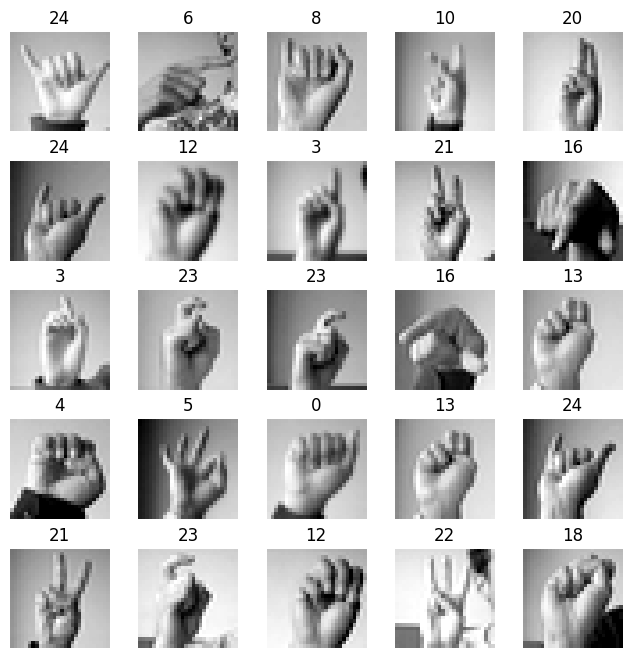

In [14]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(8,8))
fig.subplots_adjust(hspace=.3)
for i in range(5):
    for j in range(5):
        ax[i][j].axis('off')
        ax[i][j].imshow(train_images.iloc[[i+(j*5)], :].to_numpy().astype(np.uint8).reshape(28, 28), cmap='gray')
        ax[i][j].set_title(train_labels[i+(j*5)])

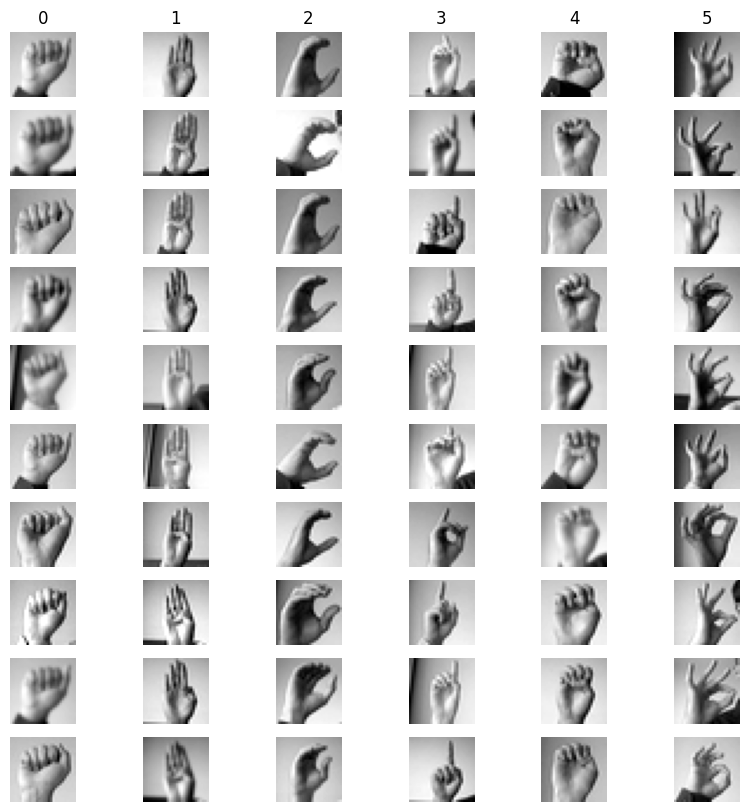

In [17]:
fig, ax = plt.subplots(nrows=10, ncols=6, figsize=(10,10))

# I know these for loops look weird, but this way num_i is only computed once for each class
# Trust me the way I had this before was more normal, but this is more efficient
for i in range(6): # Column by column
    num_i = train_images[train_labels == i]
    ax[0][i].set_title(i)
    for j in range(10): # Row by row
        ax[j][i].axis('off')
        ax[j][i].imshow(num_i.iloc[j, :].to_numpy().astype(np.uint8).reshape(28, 28), cmap='gray')

In [ ]:
IMG_SIZE = 28 # size of images in MNIST
# Also the images only have one color channel
# So 3D size = (1, 28, 28)

# Transformations for the train
train_trans = transforms.Compose(([
    transforms.ToPILImage(),
    transforms.RandomCrop(IMG_SIZE), 
    transforms.ToTensor(), # divides by 255
  #  transforms.Normalize((0.5,), (0.5,))
]))

# Transformations for the validation & test sets
val_trans = transforms.Compose(([
    transforms.ToPILImage(),
    transforms.ToTensor(), # divides by 255
   # transforms.Normalize((0.1307,), (0.3081,))
]))